# Malicious URL CLassification

In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib.colors import hex2color
import matplotlib.pyplot as plt

from gensim.models import Word2Vec

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

import joblib

## Import the dataset

In [2]:
DATASET_FILE = "./datasets/malicious_phish.csv" # Original dataset
# DATASET_FILE = "./datasets/combined_urls.csv" # Combined dataset (original + generated)

df = pd.read_csv(DATASET_FILE)

df.rename(columns={"type": "target"}, inplace=True)
df['target'] = df['target'].map(lambda x: 'malicious' if x != 'benign' else 'benign')

df["target"].value_counts()


target
benign       428103
malicious    223088
Name: count, dtype: int64

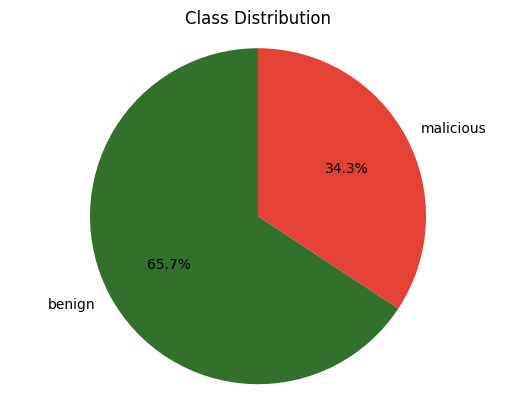

In [3]:
distribution = dict(df["target"].value_counts())

# Set up the figure with a white background
fig, ax = plt.subplots(facecolor='white')

dull_red = hex2color('#E34234')
dull_green = hex2color('#32712C')

# Plotting the pie chart
ax.pie(distribution.values(), labels=distribution.keys(), colors=[dull_green, dull_red], autopct='%1.1f%%', startangle=90)
ax.set_title('Class Distribution')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the pie chart
plt.show()

## URL Tokenization and Word Embedding with Word2Vec

In [4]:
def preprocess_url(url):
    # Remove sequential strings following '#' and '?'
    url = re.sub(r"#.*", "", url)
    url = re.sub(r"\?.*", "", url)

    # Split the URL into protocol and rest (domain, path and file)
    protocol, rest = url.split("://", 1) if "://" in url else ("", url)

    # Split the rest into domain and rest (path and file)
    domain, rest = rest.split("/", 1) if "/" in rest else (rest, "")
    
    # Split the rest into path and file
    path, file = rest.rsplit("/", 1) if "/" in rest else (rest, "")

    return [protocol, domain, path, file]

# Token extraction
tokenized_urls = [preprocess_url(url) for url in df['url'].tolist()]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_urls, vector_size=100, window=5, min_count=1, workers=4)
model.save("models/word2vec_model.model")

In [5]:
model = Word2Vec.load("models/word2vec_model.model")

In [6]:
# Function to get the aggregated embedding for a URL
def get_url_embedding(url_tokens, model):
    embeddings = [model.wv[token] for token in url_tokens if token in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Generate embeddings for each URL
url_embeddings = [get_url_embedding(url_token, model) for url_token in tokenized_urls]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(url_embeddings, df['target'].tolist(), test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the basic statistics of the training set
data_counts = {
    "train": pd.Series(y_train).value_counts().to_list(),
    "test": pd.Series(y_test).value_counts().to_list(),
    "validation": pd.Series(y_val).value_counts().to_list(),
    "total": pd.Series(df['target'].tolist()).value_counts().to_list(),
}
pd.DataFrame(data_counts, index=["benign", "malicious"])

,train,test,validation,total
benign,342325,42748,43030,428103
malicious,178627,22371,22090,223088


## Naive Bayes Classifier

In [8]:
nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

joblib.dump(nb_classifier, "models/nb_classifier.joblib")

['models/nb_classifier.joblib']

In [9]:
nb_classifier = joblib.load("models/nb_classifier.joblib")

nb_classifier.score(X_test, y_test)

0.8296042629647261

In [10]:
y_pred = nb_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["benign", "malicious"], zero_division=0, digits=4))

              precision    recall  f1-score   support

      benign     0.8540    0.8932    0.8731     42748
   malicious     0.7763    0.7081    0.7406     22371

    accuracy                         0.8296     65119
   macro avg     0.8151    0.8006    0.8069     65119
weighted avg     0.8273    0.8296    0.8276     65119



## Random Forest Classifier

In [11]:
rf_classifier = RandomForestClassifier(n_estimators=10, n_jobs=10)

rf_classifier.fit(X_train, y_train)

joblib.dump(rf_classifier, "models/rf_classifier.joblib")

['models/rf_classifier.joblib']

In [12]:
rf_classifier = joblib.load("models/rf_classifier.joblib")

# Tune hyperparameters using X_val and y_val
rf_classifier.score(X_val, y_val)

0.909428746928747

In [13]:
y_pred = rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["benign", "malicious"], zero_division=0, digits=4))

              precision    recall  f1-score   support

      benign     0.8899    0.9808    0.9331     42748
   malicious     0.9545    0.7681    0.8512     22371

    accuracy                         0.9077     65119
   macro avg     0.9222    0.8745    0.8922     65119
weighted avg     0.9121    0.9077    0.9050     65119



# CNN Implementation

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from sklearn.preprocessing import LabelEncoder

In [38]:
label_encoder = LabelEncoder()

all_labels = np.concatenate((y_train, y_test, y_val))
label_encoder.fit(all_labels)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)
X_val = np.array(X_val)

In [22]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(100, 1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/10
16280/16280 [==============================] - 35s 2ms/step - loss: 0.3537 - accuracy: 0.8548 - val_loss: 0.0097 - val_accuracy: 0.0000e+00
Epoch 2/10
16280/16280 [==============================] - 36s 2ms/step - loss: 0.3246 - accuracy: 0.8711 - val_loss: 0.7381 - val_accuracy: 0.0000e+00
Epoch 3/10
16280/16280 [==============================] - 42s 3ms/step - loss: 0.3165 - accuracy: 0.8743 - val_loss: 1.9497 - val_accuracy: 0.0000e+00
Epoch 4/10
16280/16280 [==============================] - 40s 2ms/step - loss: 0.3115 - accuracy: 0.8757 - val_loss: 1.9931 - val_accuracy: 0.0000e+00
Epoch 5/10
16280/16280 [==============================] - 39s 2ms/step - loss: 0.3069 - accuracy: 0.8768 - val_loss: 2.9580 - val_accuracy: 0.0000e+00
Epoch 6/10
16280/16280 [==============================] - 36s 2ms/step - loss: 0.3033 - accuracy: 0.8777 - val_loss: 0.9981 - val_accuracy: 0.0000e+00
Epoch 7/10
16280/16280 [==============================] - 35s 2ms/step - loss: 0.3017 - accura

In [39]:
# Evaluate the model
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Convert the labels back to their original values
class_report = classification_report(y_test, binary_predictions, target_names=["benign", "malicious"], zero_division=0)


print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

2035/2035 [==============================] - 2s 939us/step
Accuracy: 0.8817702974554278
Confusion Matrix:
[[42172   576]
 [ 7123 15248]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.86      0.99      0.92     42748
   malicious       0.96      0.68      0.80     22371

    accuracy                           0.88     65119
   macro avg       0.91      0.83      0.86     65119
weighted avg       0.89      0.88      0.88     65119



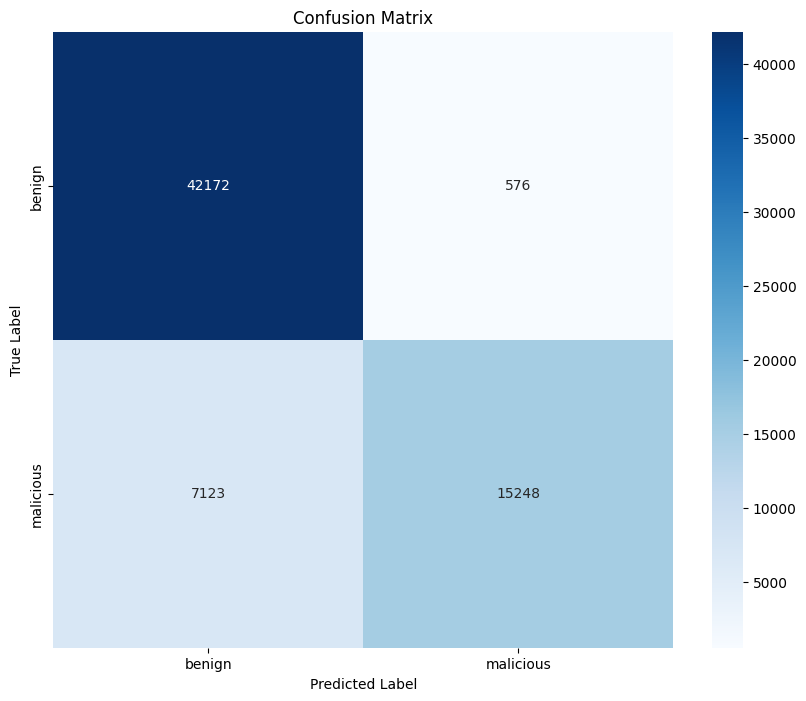

In [33]:
# Display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ["benign", "malicious"]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
